In [1]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="mpmdb", password="coap")
  con.set_session(readonly=True, autocommit=False)
    

In [3]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
  JOIN event e ON e.observer_id = d.dnid
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

custom_mpm_server_conf_1client_0attackers_newreala
custom_mpm_server_conf_1client_1attackers_newreala
regular_delay_90conns_1client_1attackers_longrunning_newreala


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system
0,custom_mpm_server_conf_1client_0attackers_newr...,1,4,1,originserver,microcloud,ubuntu1804-std
1,custom_mpm_server_conf_1client_0attackers_newr...,1,5,4,proxy,microcloud,ubuntu1804-std
2,custom_mpm_server_conf_1client_0attackers_newr...,1,2,5,client1,microcloud,ubuntu1804-std
3,custom_mpm_server_conf_1client_1attackers_newr...,1,16,1,originserver,microcloud,ubuntu1804-std
4,custom_mpm_server_conf_1client_1attackers_newr...,1,18,2,receiver,microcloud,ubuntu1804-std
5,custom_mpm_server_conf_1client_1attackers_newr...,1,13,3,attacker,microcloud,ubuntu1804-std
6,custom_mpm_server_conf_1client_1attackers_newr...,1,17,4,proxy,microcloud,ubuntu1804-std
7,custom_mpm_server_conf_1client_1attackers_newr...,1,14,5,client1,microcloud,ubuntu1804-std
8,regular_delay_90conns_1client_1attackers_longr...,1,10,1,originserver,microcloud,ubuntu1804-std
9,regular_delay_90conns_1client_1attackers_longr...,1,12,2,receiver,microcloud,ubuntu1804-std


In [15]:
exp_id = "regular_delay_90conns_1client_1attackers_longrunning_newreala"

node_map_node_id = dict()
node_map_dnid = dict()

df = lay_of_the_land
records = df[(df["exp_id"] == exp_id)][["node_name", "dnid", "node_id"]].to_records(index=False)
client_node_ids = set()
client_dnids = set()
proxy_node_id = None
for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    if node_name.startswith("client"):
        client_node_ids.add(node_id)
        client_dnids.add(dnid)
    elif node_name == 'proxy':
        proxy_node_id = node_id
    
pprint(node_map_node_id)
pprint(node_map_dnid)
pprint(client_node_ids)
pprint(client_dnids)
pprint(proxy_node_id)

{'attacker': 3, 'client1': 7, 'originserver': 1, 'proxy': 4, 'receiver': 2}
{'attacker': 7, 'client1': 8, 'originserver': 10, 'proxy': 11, 'receiver': 12}
{7}
{8}
4


In [16]:
summary_sql = f"""
SELECT 
	n.node_name AS observer,
	e.trial,
	COUNT (DISTINCT e.message_marker) AS unique_messages,
	COUNT (e.message_marker) AS total_messages,
	MIN(e.observe_timestamp) min_timestamp_sec,
	MAX(e.observe_timestamp) max_timestamp_sec,
	MAX(e.observe_timestamp) - MIN(e.observe_timestamp) active_time_sec
FROM 
	deployed_node d 
	JOIN node n ON n.node_id = d.node_id
	JOIN "event" e ON e.observer_id = d.dnid
WHERE 
	d.exp_id = '{exp_id}'
GROUP BY
	n.node_name,
	e.trial
"""

sdf = pd.read_sql_query(summary_sql, con)
con.commit()
sdf

,observer,trial,unique_messages,total_messages,min_timestamp_sec,max_timestamp_sec,active_time_sec
0,attacker,1,506054,506054,1.642718e+09,1.642718e+09,19.842131
1,client1,1,9645,28940,1.642718e+09,1.642718e+09,597.830468
2,originserver,1,122426,244913,1.642718e+09,1.642718e+09,598.973403
3,proxy,1,515687,1725270,1.642718e+09,1.642718e+09,599.161934
4,receiver,1,444825,444825,1.642718e+09,1.642718e+09,80.121903


In [17]:
client_messages_sql = f"""
WITH client_msgs AS (
SELECT
    dn.exp_id,
	e.trial,
	e.observer_id,
    e.message_marker,
	e.observe_timestamp,
	m.src_id, 
    cm.coap_code,
	cm.coap_retransmitted
FROM
	event e
	JOIN deployed_node dn ON dn.dnid = e.observer_id
	JOIN message m ON e.message_id = m.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
WHERE
	e.observer_id IN ({','.join(map(str, client_dnids))}) -- all client dnids
ORDER BY
	e.observe_timestamp
), client_sends AS (
SELECT *
FROM client_msgs
WHERE src_id != {proxy_node_id} -- message source is not the proxy 
), client_recvs AS (
SELECT *
FROM client_msgs
WHERE src_id = {proxy_node_id} -- message source is the proxy 
), msgs_summary AS (
SELECT 
	cm.exp_id,
	cm.trial,
	cm.observer_id,
	cm.message_marker,
	COUNT(cm.*) AS num_observations,
	SUM(CASE WHEN cm.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM 
	client_msgs cm
GROUP BY
	cm.exp_id, cm.trial, cm.observer_id, cm.message_marker
ORDER BY 
	cm.exp_id, cm.trial, cm.observer_id, cm.message_marker
), timestamps_summary AS (
SELECT 
	cm.exp_id, 
	cm.trial, 
	cm.observer_id, 
	MIN(observe_timestamp) AS min_observe_timestamp, 
	MAX(observe_timestamp) AS max_observe_timestamp
FROM client_msgs cm
GROUP BY cm.exp_id, cm.trial, cm.observer_id
ORDER BY cm.exp_id, cm.trial, cm.observer_id
), main_table AS (
SELECT 
	cs.exp_id,
	cs.trial,
	cs.observer_id,
    cs.message_marker,
	1e3 * (MAX(cr.observe_timestamp) - MIN(cs.observe_timestamp)) AS rtt_ms_first_transmission,
	1e3 * (MAX(cr.observe_timestamp) - MAX(cs.observe_timestamp)) AS rtt_ms_last_transmission,
	-- MIN is ok to use as "first in aggregation group" since all 
	-- values are expected to be the same in the GROUP BY group
	MIN(cs.observe_timestamp) - MIN(min_observe_timestamp) AS send_time_sec,
	MAX(cr.observe_timestamp) - MIN(min_observe_timestamp) AS recv_time_sec,
	MIN(ms.num_observations) AS num_observations,
	MIN(ms.num_retransmissions) AS num_retransmissions
FROM 
	client_sends cs
	LEFT JOIN client_recvs cr
		ON cs.exp_id = cr.exp_id 
		AND cs.trial = cr.trial
		AND cs.observer_id = cr.observer_id
		AND cs.message_marker = cr.message_marker
	JOIN timestamps_summary ts
		ON cs.exp_id = ts.exp_id 
		AND cs.trial = ts.trial
		AND cs.observer_id = ts.observer_id
	, msgs_summary ms
WHERE
	cs.exp_id = ms.exp_id
	AND cs.trial = ms.trial
	AND cs.observer_id = ms.observer_id
	AND cs.message_marker = ms.message_marker
GROUP BY cs.exp_id, cs.trial, cs.observer_id, cs.message_marker
ORDER BY cs.exp_id, cs.trial, cs.observer_id, cs.message_marker
), rps_stats AS (
SELECT 
	mt.exp_id,
	mt.trial,
	mt.observer_id,
	COUNT(DISTINCT mt.message_marker) AS num_messages,
	MAX(mt.recv_time_sec) AS last_receive_time_sec,
	MIN(mt.send_time_sec) AS first_send_time_sec,
	COUNT(DISTINCT mt.message_marker) / (MAX(mt.recv_time_sec) - MIN(mt.send_time_sec)) AS average_rps
FROM main_table mt
GROUP BY mt.exp_id, mt.trial, mt.observer_id
)

SELECT mt.*, rs.average_rps, rs.first_send_time_sec, rs.last_receive_time_sec
FROM main_table mt
JOIN rps_stats rs
	ON mt.exp_id = rs.exp_id
	AND mt.trial = rs.trial
	AND mt.observer_id = rs.observer_id
"""

rtts_df = pd.read_sql_query(client_messages_sql, con)
con.commit()

rtts_df

,exp_id,trial,observer_id,message_marker,rtt_ms_first_transmission,rtt_ms_last_transmission,send_time_sec,recv_time_sec,num_observations,num_retransmissions,average_rps,first_send_time_sec,last_receive_time_sec
0,regular_delay_90conns_1client_1attackers_longr...,1,8,1,205.047131,205.047131,0.000000,0.205047,3,0,16.133345,0.0,597.830151
1,regular_delay_90conns_1client_1attackers_longr...,1,8,2,56.411982,56.411982,0.229093,0.285505,3,0,16.133345,0.0,597.830151
2,regular_delay_90conns_1client_1attackers_longr...,1,8,3,55.725813,55.725813,0.289725,0.345451,3,0,16.133345,0.0,597.830151
3,regular_delay_90conns_1client_1attackers_longr...,1,8,4,56.060076,56.060076,0.348850,0.404910,3,0,16.133345,0.0,597.830151
4,regular_delay_90conns_1client_1attackers_longr...,1,8,5,55.258989,55.258989,0.408617,0.463876,3,0,16.133345,0.0,597.830151
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9640,regular_delay_90conns_1client_1attackers_longr...,1,8,515695,52.937269,52.937269,597.616809,597.669746,3,0,16.133345,0.0,597.830151
9641,regular_delay_90conns_1client_1attackers_longr...,1,8,515696,53.139925,53.139925,597.670072,597.723212,3,0,16.133345,0.0,597.830151
9642,regular_delay_90conns_1client_1attackers_longr...,1,8,515697,53.206921,53.206921,597.723499,597.776706,3,0,16.133345,0.0,597.830151
9643,regular_delay_90conns_1client_1attackers_longr...,1,8,515698,52.927971,52.927971,597.777223,597.830151,3,0,16.133345,0.0,597.830151


In [18]:
rtts_df[["rtt_ms_first_transmission", "rtt_ms_last_transmission"]].describe()

,rtt_ms_first_transmission,rtt_ms_last_transmission
count,9644.000000,9644.000000
mean,61.508555,56.661282
std,638.810856,249.952235
min,52.422047,52.422047
25%,53.100824,53.100824
50%,53.158045,53.158045
75%,53.220034,53.220034
max,61312.147856,23779.629946


In [ ]:
%matplotlib notebook

ignore_clients = {}
ignore_trials = {}

ax = None
kind = "line"
color_map = {(1,0): "orange", (1,1): "blue", (1,2): "red", (1,3): "black",
             (2,0): "skyblue", (2,1): "brown", (2,2): "gold", (2,3): "maroon",
             (3,0): "silver", (3,1): "green", (3,2): "purple", (3,3): "pink"}
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    for client_number, src_id in enumerate(trial_df["observer_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = trial_df[trial_df["observer_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        
        # RTT since first transmission
        last_txmission = label + "_last_txmission"
        plot_args = {"kind": kind,
                     "x": "recv_time_sec",
                     "y": "rtt_ms_first_transmission",
                     "label": last_txmission,
                     "marker": 'X'}
        if ax:
            plot_args += {"ax": ax}
        
        ax = client_trial_df.plot(**plot_args)
        plot_args["ax"] = ax

        # RTT since last transmission
        first_txmission = label + "_first_txmission"
        plot_args["label"] = first_txmission
        plot_args["y"] = "rtt_ms_last_transmission"
        ax = client_trial_df.plot(**plot_args)

ax.set_title("Client Rtt vs Time")
ax.set_ylabel("RTT [ms]")
plt.show()

<IPython.core.display.Javascript object>


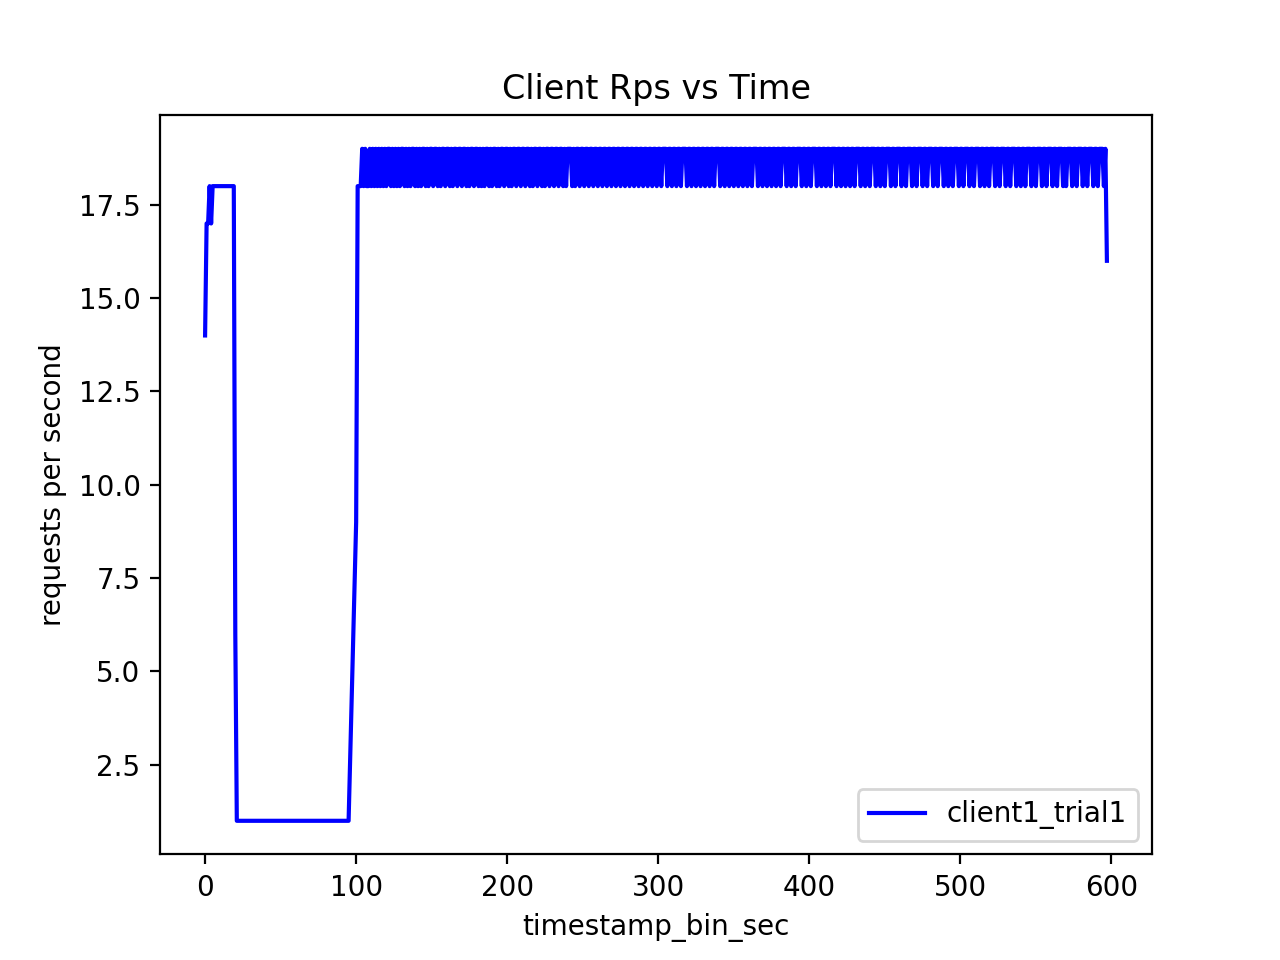

,timestamp_bin_sec,observer_id,packets_per_second
0,0.0,8,14
1,1.0,8,17
2,2.0,8,17
3,3.0,8,18
4,4.0,8,17
...,...,...,...
517,593.0,8,19
518,594.0,8,19
519,595.0,8,18
520,596.0,8,19


In [20]:
trial_df["timestamp_bin_sec"] = np.floor(trial_df["recv_time_sec"])

ignore_clients = {}
ignore_trials = {4, 5}

ax = None
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["recv_time_sec"].min()
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["recv_time_sec"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec", "observer_id"]).agg(\
                                             packets_per_second=("average_rps", "count")).reset_index()
    
    for client_number, src_id in enumerate(trial_df["observer_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = time_stats_df[time_stats_df["observer_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        color = color_map[(t, client_number)]
        ax = client_trial_df.plot(kind="line", x="timestamp_bin_sec", y="packets_per_second", ax=ax, color=color, label=label)

ax.set_title("Client Rps vs Time")
ax.set_ylabel("requests per second")
plt.show()

time_stats_df

<IPython.core.display.Javascript object>


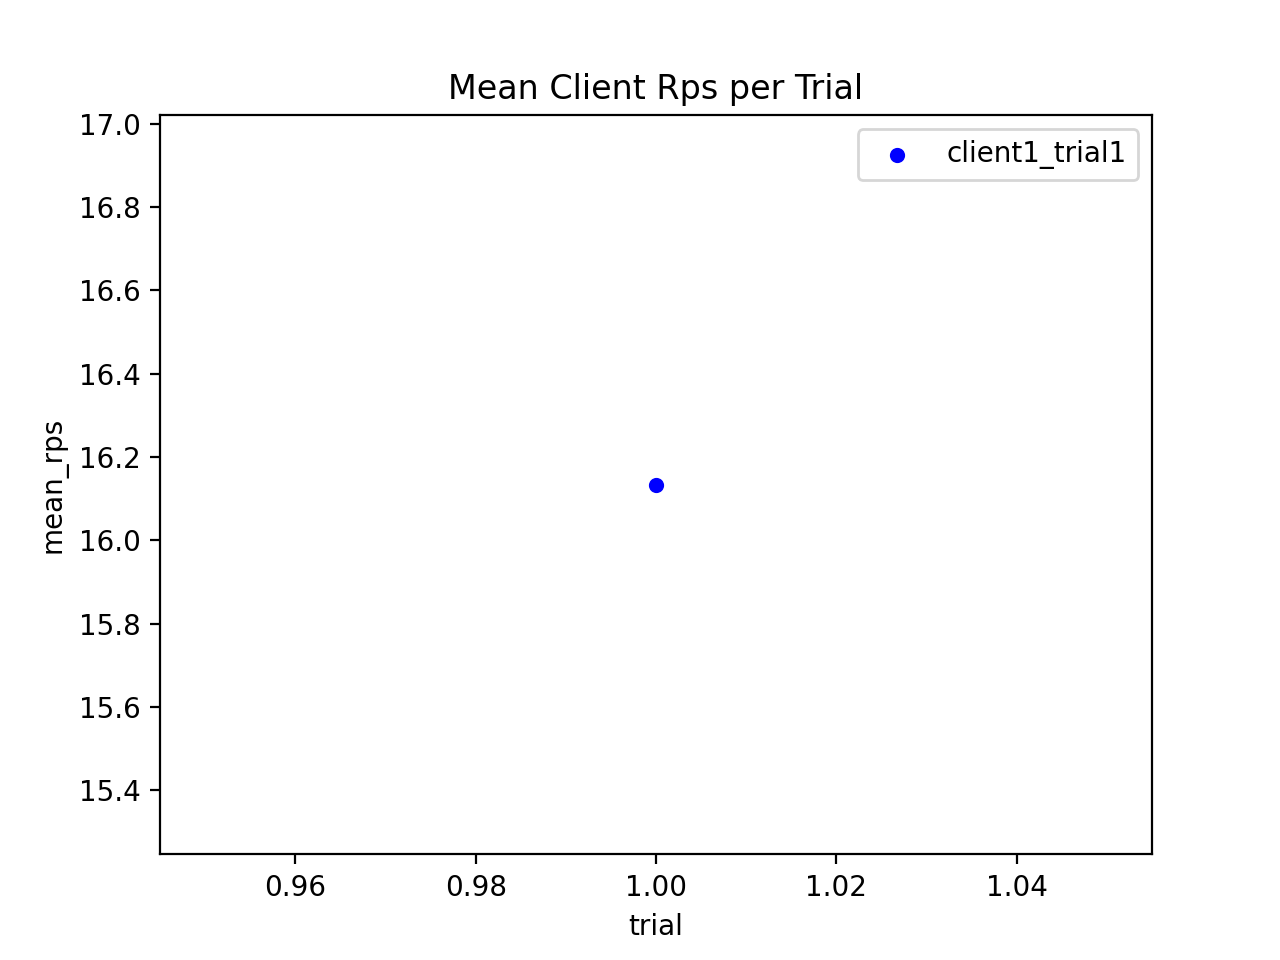

   trial   mean_rps
0      1  16.133345


,observer_id,trial,mean_rps
0,8,1,16.133345


In [21]:
gdf = rtts_df.groupby(by=["observer_id", "trial"]).agg(mean_rps=("average_rps", "mean")).reset_index()

ax = None
for t in gdf["trial"].unique():
    tdf = gdf[gdf["trial"] == t]
    for client_number, src_id in enumerate(tdf["observer_id"].unique(), start=1):
        cdf = tdf[tdf["observer_id"] == src_id]
        cdf["client_number"] = client_number
        ax = cdf.plot(kind="scatter", x="trial", y="mean_rps", ax=ax, label=f"client{client_number}_trial{t}", color=color_map[(t, client_number)])
        
print(gdf.groupby(by=["trial"]).mean().reset_index()[["trial", "mean_rps"]])
       
ax.set_title("Mean Client Rps per Trial")
plt.show()

gdf

In [22]:
attack_dbg_sql = f"""

WITH proxy AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = {node_map_dnid["proxy"]} -- proxy is observer
), proxy_from_server AS (
SELECT 
	*
FROM 
	proxy
WHERE
	src_id = {node_map_node_id["originserver"]} AND dst_id = {node_map_node_id["proxy"]} -- server --> proxy
), proxy_from_attacker AS (
SELECT 
	*
FROM 
	proxy
WHERE
	src_id = {node_map_node_id["receiver"]} AND dst_id = {node_map_node_id["proxy"]} -- attacker (spoofing as receiver) --> proxy
), exp_server AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = {node_map_dnid["originserver"]} -- server is observer
), server_from_proxy AS (
SELECT 
	*
FROM 
	exp_server
WHERE
	src_id = {node_map_node_id["proxy"]} AND dst_id = {node_map_node_id["originserver"]} -- proxy --> server
), receiver AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = {node_map_dnid["receiver"]} -- receiver is observer
), experiment_timestamps AS (
SELECT 
	MIN(x.observe_timestamp) AS min_timestamp,
	MAX(x.observe_timestamp) AS max_timestamp
FROM 
	event x 
WHERE 
	x.observer_id = {node_map_dnid["proxy"]} OR x.observer_id IN ({','.join(map(str, client_dnids))}) -- proxy or client
), main_table AS (
SELECT 
	dn.exp_id,
	e.trial,
	e.message_marker,
	
	r.coap_type,
	r.coap_code,
	r.coap_retransmitted,
	
	sfp.src_id AS sfp_src_id,
	sfp.dst_id AS sfp_dst_id,
	
	e.observe_timestamp - min_timestamp   AS a_observe_timestamp,
	pfa.observe_timestamp - min_timestamp AS pfa_observe_timestamp,
	sfp.observe_timestamp - min_timestamp AS sfp_observe_timestamp,
	pfs.observe_timestamp - min_timestamp AS pfs_observe_timestamp,
	r.observe_timestamp - min_timestamp   AS r_observe_timestamp,
	
	1e3 * (pfa.observe_timestamp - e.observe_timestamp)   AS attacker_to_proxy_ms,
	1e3 * (sfp.observe_timestamp - pfa.observe_timestamp) AS proxy_to_server_ms,
	1e3 * (pfs.observe_timestamp - sfp.observe_timestamp) AS server_to_proxy_ms,
	1e3 * (r.observe_timestamp   - pfs.observe_timestamp) AS proxy_to_receiver_ms,
	1e3 * (r.observe_timestamp   - e.observe_timestamp)   AS attacker_to_receiver_ms
FROM
	event e
	JOIN deployed_node dn             ON dn.dnid            = e.observer_id
	LEFT JOIN proxy_from_attacker pfa ON pfa.message_marker  = e.message_marker
	LEFT JOIN server_from_proxy sfp   ON sfp.message_marker = e.message_marker
	LEFT JOIN proxy_from_server pfs   ON pfs.message_marker = e.message_marker
	LEFT JOIN receiver r              ON r.message_marker   = e.message_marker
	, experiment_timestamps
WHERE 
	e.observer_id = {node_map_dnid["attacker"]} -- attacker is observer for e
), main_table_summary AS (
	SELECT
		COUNT(DISTINCT x.message_marker) AS num_unique_messages,
		COUNT(x.message_marker) AS num_messages
	FROM
		main_table x
), massaged_main_table AS (
SELECT 
	mts.*,
	mt.*
FROM
	main_table mt,
	main_table_summary mts
ORDER BY
	mt.exp_id,
	mt.trial,
	mt.message_marker
), duplicate_messages AS (
SELECT a.*
FROM massaged_main_table a
JOIN (SELECT exp_id, trial, message_marker, COUNT(*)
FROM massaged_main_table 
GROUP BY exp_id, trial, message_marker
HAVING count(*) > 1 ) b
ON a.exp_id = b.exp_id
AND a.trial = b.trial
AND a.message_marker = b.message_marker
ORDER BY a.exp_id, a.trial, a.message_marker
)

SELECT *
FROM massaged_main_table 
;
"""

print(attack_dbg_sql)

adbgdf = pd.read_sql_query(attack_dbg_sql, con)
adbgdf["sent_time_ms"] = adbgdf["a_observe_timestamp"]
adbgdf.sort_values(by="sent_time_ms", inplace=True)
con.commit()

adbgdf



WITH proxy AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = 11 -- proxy is observer
), proxy_from_server AS (
SELECT 
	*
FROM 
	proxy
WHERE
	src_id = 1 AND dst_id = 4 -- server --> proxy
), proxy_from_attacker AS (
SELECT 
	*
FROM 
	proxy
WHERE
	src_id = 2 AND dst_id = 4 -- attacker (spoofing as receiver) --> proxy
), exp_server AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = 10 -- server is observer
), server_from_proxy AS (
SELECT 
	*
FROM 
	exp_server
WHERE
	src_id = 4 AND dst_id = 1 -- proxy --> server
), receiver AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	eve

,num_unique_messages,num_messages,exp_id,trial,message_marker,coap_type,coap_code,coap_retransmitted,sfp_src_id,sfp_dst_id,...,pfa_observe_timestamp,sfp_observe_timestamp,pfs_observe_timestamp,r_observe_timestamp,attacker_to_proxy_ms,proxy_to_server_ms,server_to_proxy_ms,proxy_to_receiver_ms,attacker_to_receiver_ms,sent_time_ms
0,506054,1009542,regular_delay_90conns_1client_1attackers_longr...,1,359,ack,content,False,4.0,1.0,...,20.283952,20.296192,20.387646,20.450094,51.773787,12.239933,91.454268,62.448025,217.916012,20.232178
1,506054,1009542,regular_delay_90conns_1client_1attackers_longr...,1,359,ack,content,False,4.0,1.0,...,20.283947,20.296192,20.387646,20.450094,51.768780,12.244940,91.454268,62.448025,217.916012,20.232178
2,506054,1009542,regular_delay_90conns_1client_1attackers_longr...,1,360,ack,content,False,4.0,1.0,...,20.284229,20.297093,20.388508,20.450064,51.815033,12.863874,91.415167,61.556101,217.650175,20.232414
3,506054,1009542,regular_delay_90conns_1client_1attackers_longr...,1,360,ack,content,False,4.0,1.0,...,20.284220,20.297093,20.388508,20.450064,51.806211,12.872696,91.415167,61.556101,217.650175,20.232414
4,506054,1009542,regular_delay_90conns_1client_1attackers_longr...,1,361,ack,content,False,4.0,1.0,...,20.284233,20.296482,20.387890,20.450013,51.813841,12.248993,91.408014,62.123060,217.593908,20.232419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009537,506054,1009542,regular_delay_90conns_1client_1attackers_longr...,1,506414,ack,bad_gateway,False,NaN,NaN,...,40.126265,NaN,NaN,100.448368,52.062988,NaN,NaN,NaN,60374.166012,40.074202
1009538,506054,1009542,regular_delay_90conns_1client_1attackers_longr...,1,506415,ack,bad_gateway,False,NaN,NaN,...,40.126270,NaN,NaN,100.448390,52.021027,NaN,NaN,NaN,60374.140978,40.074249
1009539,506054,1009542,regular_delay_90conns_1client_1attackers_longr...,1,506415,ack,bad_gateway,False,NaN,NaN,...,40.126268,NaN,NaN,100.448390,52.018881,NaN,NaN,NaN,60374.140978,40.074249
1009540,506054,1009542,regular_delay_90conns_1client_1attackers_longr...,1,506416,ack,bad_gateway,False,NaN,NaN,...,40.126271,NaN,NaN,100.448383,51.961899,NaN,NaN,NaN,60374.073982,40.074309


<IPython.core.display.Javascript object>


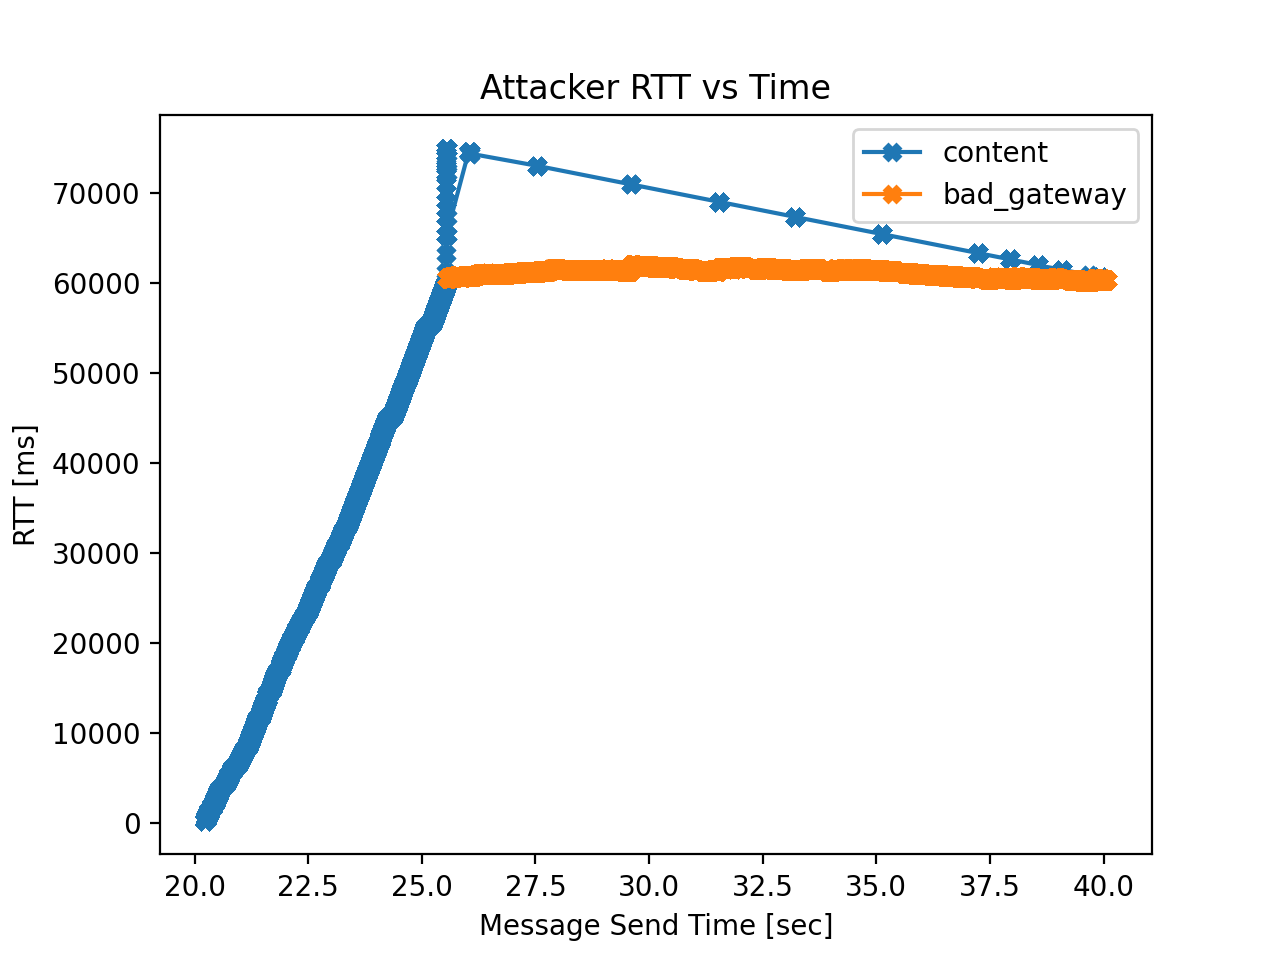

In [23]:
# Plot attacker rtt vs time

ax = None
x="sent_time_ms"
y="attacker_to_receiver_ms"
kind="line"
for coap_code in adbgdf["coap_code"].unique():
    if coap_code is None:
        continue
    _df = adbgdf[adbgdf["coap_code"] == coap_code]
    plot_args = {"kind": kind,
                 "x": x,
                 "y": y,
                 "ax": ax,
                 "marker": "X",
                 "label": coap_code}
    ax = _df.plot(**plot_args)

ax.set_title("Attacker RTT vs Time")
ax.set_ylabel("RTT [ms]")
ax.set_xlabel("Message Send Time [sec]")
plt.show()

<IPython.core.display.Javascript object>


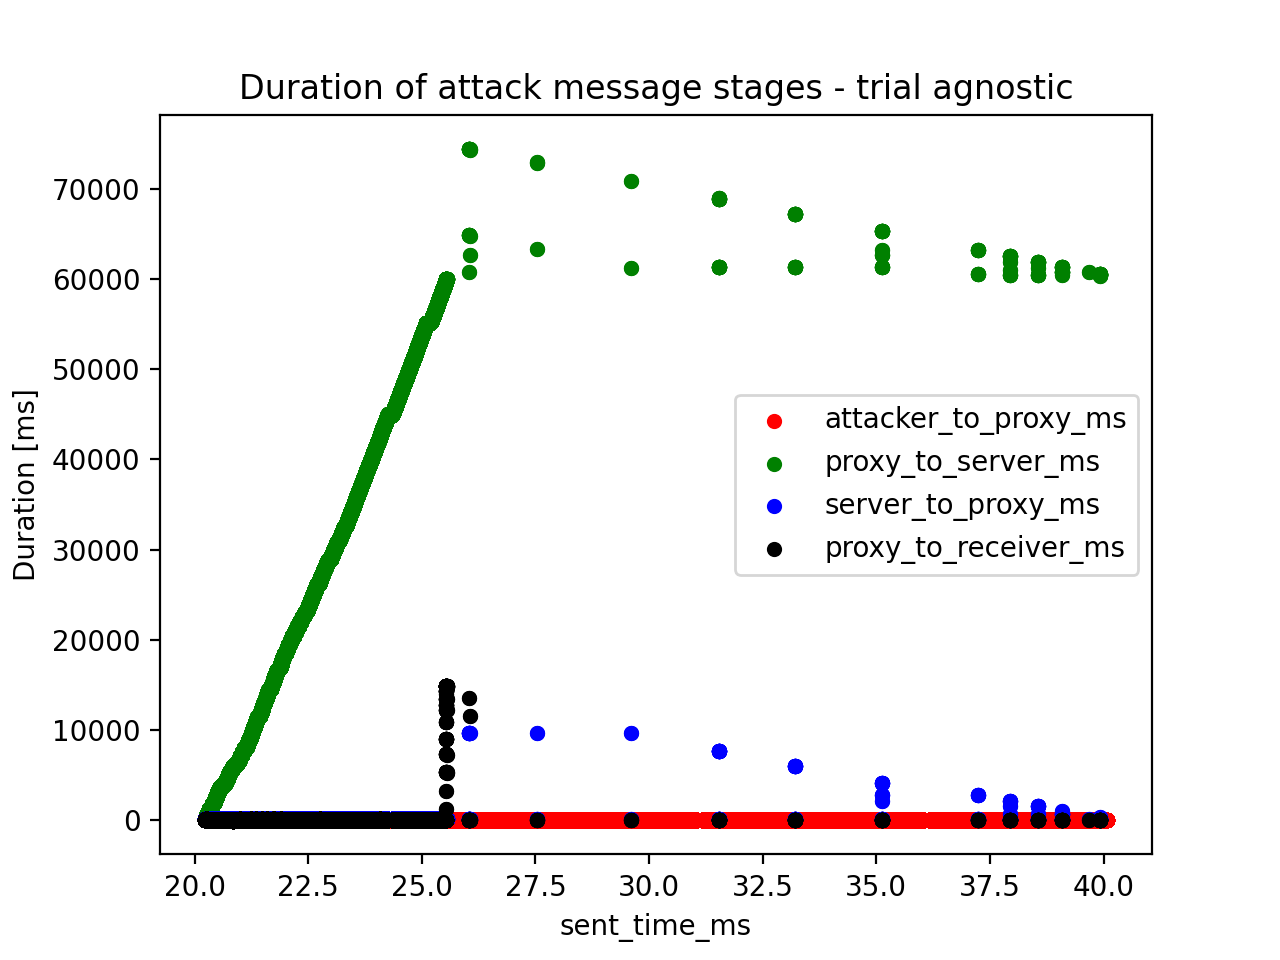

In [24]:
# Plot the duration of different stages of the attack messages

x="sent_time_ms"
kind="scatter"
ax = None
ax = adbgdf.plot(kind=kind, x=x, y="attacker_to_proxy_ms", ax=ax, label="attacker_to_proxy_ms", color='red')
ax = adbgdf.plot(kind=kind, x=x, y="proxy_to_server_ms", ax=ax, label="proxy_to_server_ms", color='green')
ax = adbgdf.plot(kind=kind, x=x, y="server_to_proxy_ms", ax=ax, label="server_to_proxy_ms", color='blue')
ax = adbgdf.plot(kind=kind, x=x, y="proxy_to_receiver_ms", ax=ax, label="proxy_to_receiver_ms", color='black')

ax.set_ylabel("Duration [ms]")
ax.set_title("Duration of attack message stages - trial agnostic")
ax.legend()

plt.show()